# Taxi Fare Prediction

## Step 0: Import libraries

In [2]:
%load_ext autoreload
%autoreload 2

###############################################
# Import Machine Learning Assets
###############################################
from bayes_opt import BayesianOptimization
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error   
from sklearn.model_selection import train_test_split
import xgboost as xgb

###############################################
# Import Miscellaneous Assets
###############################################
from IPython.display import Image
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pathlib import Path
import os
from scipy.stats import anderson # Anderson-Darling Test
import sys
import seaborn as sn

parent_folder = str(Path(os.getcwd()).parent)
sys.path.insert(1, parent_folder)

from src.data.make_dataset import extract, reduce_mem_usg_pd
from src.features.build_features import remove_outliers, split_datetime, compute_distance
from src.vizualisation import vizualize


DATA_PATH = "../data/"
MODEL_PATH = "../models/"
DATASET_PATH = "brief-12"
FIGURE_PATH = "../reports/figures/"

## Step 1: Understand the Business
8 columns : the unique key, the fare amount and 6 features.

## Step 2: Get your data

In [ ]:
extracted = extract("brief-12.zip")

In [2]:
global_df = pd.read_csv(f"{DATA_PATH}interim/train.csv", nrows=4_000_000, usecols=[1, 2, 3, 4, 5, 6, 7])

## Step 3: Explore and clean your data

### Null Values

In [3]:
global_df.isnull().sum().sort_index() / len(global_df)

dropoff_latitude     0.000007
dropoff_longitude    0.000007
fare_amount          0.000000
passenger_count      0.000000
pickup_datetime      0.000000
pickup_latitude      0.000000
pickup_longitude     0.000000
dtype: float64

There appears to be an insignificant amount of null entries in the sample so it should be fine to remove them from the sample. Now we can review the statistics of the training set and the test set to find anomalies.

In [4]:
global_df = global_df.dropna()

### Outliers, Cleaning & Engineering

In [5]:
global_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fare_amount,3999971.0,11.343895,9.824417,-62.000000,6.000000,8.500000,12.500000,1273.310000
pickup_longitude,3999971.0,-72.508448,13.121801,-3426.608950,-73.992072,-73.981812,-73.967102,3439.425565
pickup_latitude,3999971.0,39.919105,8.797877,-3488.079513,40.734912,40.752625,40.767113,2912.464657
dropoff_longitude,3999971.0,-72.508713,12.893078,-3412.653087,-73.991393,-73.980156,-73.963663,3457.622350
dropoff_latitude,3999971.0,39.917893,9.716855,-3488.079513,40.734025,40.753145,40.768117,3345.917353
passenger_count,3999971.0,1.684346,1.329068,0.000000,1.000000,1.000000,2.000000,208.000000


In [3]:
global_df = remove_outliers(global_df, {"fare_amount": [1.5, 500], "pickup_longitude": [-75, -72], "pickup_latitude": [40, 42], "dropoff_longitude": [-75, -72], "dropoff_latitude": [40, 42], "passenger_count": [0, 6]})

fare_amount
Before filtering: (3999971, 7)
After filtering: (3999650, 7)
pickup_longitude
Before filtering: (3999650, 7)
After filtering: (3920366, 7)
pickup_latitude
Before filtering: (3920366, 7)
After filtering: (3919793, 7)
dropoff_longitude
Before filtering: (3919793, 7)
After filtering: (3915945, 7)
dropoff_latitude
Before filtering: (3915945, 7)
After filtering: (3915546, 7)
passenger_count
Before filtering: (3915546, 7)
After filtering: (3819142, 7)


In [7]:
global_df = reduce_mem_usg_pd(global_df)
global_df.to_csv(f"{DATA_PATH}processed/chunk.csv")

## Step 4: Enrich Your Dataset

In [5]:
global_df = pd.read_csv(f"{DATA_PATH}processed/chunk.csv")
# Compute distance to calc price per km
global_df['dist_km'] = compute_distance(global_df.pickup_longitude, global_df.pickup_latitude, global_df.dropoff_longitude, global_df.dropoff_latitude)
global_df = global_df[(global_df['dist_km'] != 0)]
global_df['price_per_km'] = global_df['fare_amount'] / global_df['dist_km']

# Split dt
# global_df = split_datetime(global_df, 1)
# global_df = global_df.drop(['pickup_datetime'], axis=1)

print(global_df.shape[0])

3885600


## Step 5: Build Helpfull Vizualizations

### Distribution

#### Visual Normality Checks

##### Histogram Plot

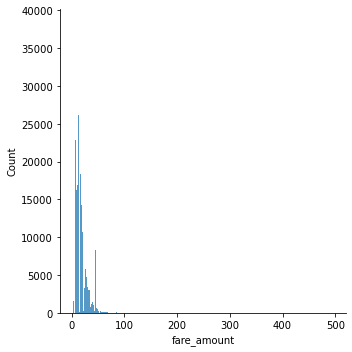

In [30]:
sn.displot(global_df["fare_amount"])

Fare seems to be not normally distributed, let's check it with a statistical normality test.

#### Statistical Normality Tests

##### Anderson-Darling Test

In [32]:
# normality test
result = anderson(global_df.fare_amount)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: nan
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


### Correlations

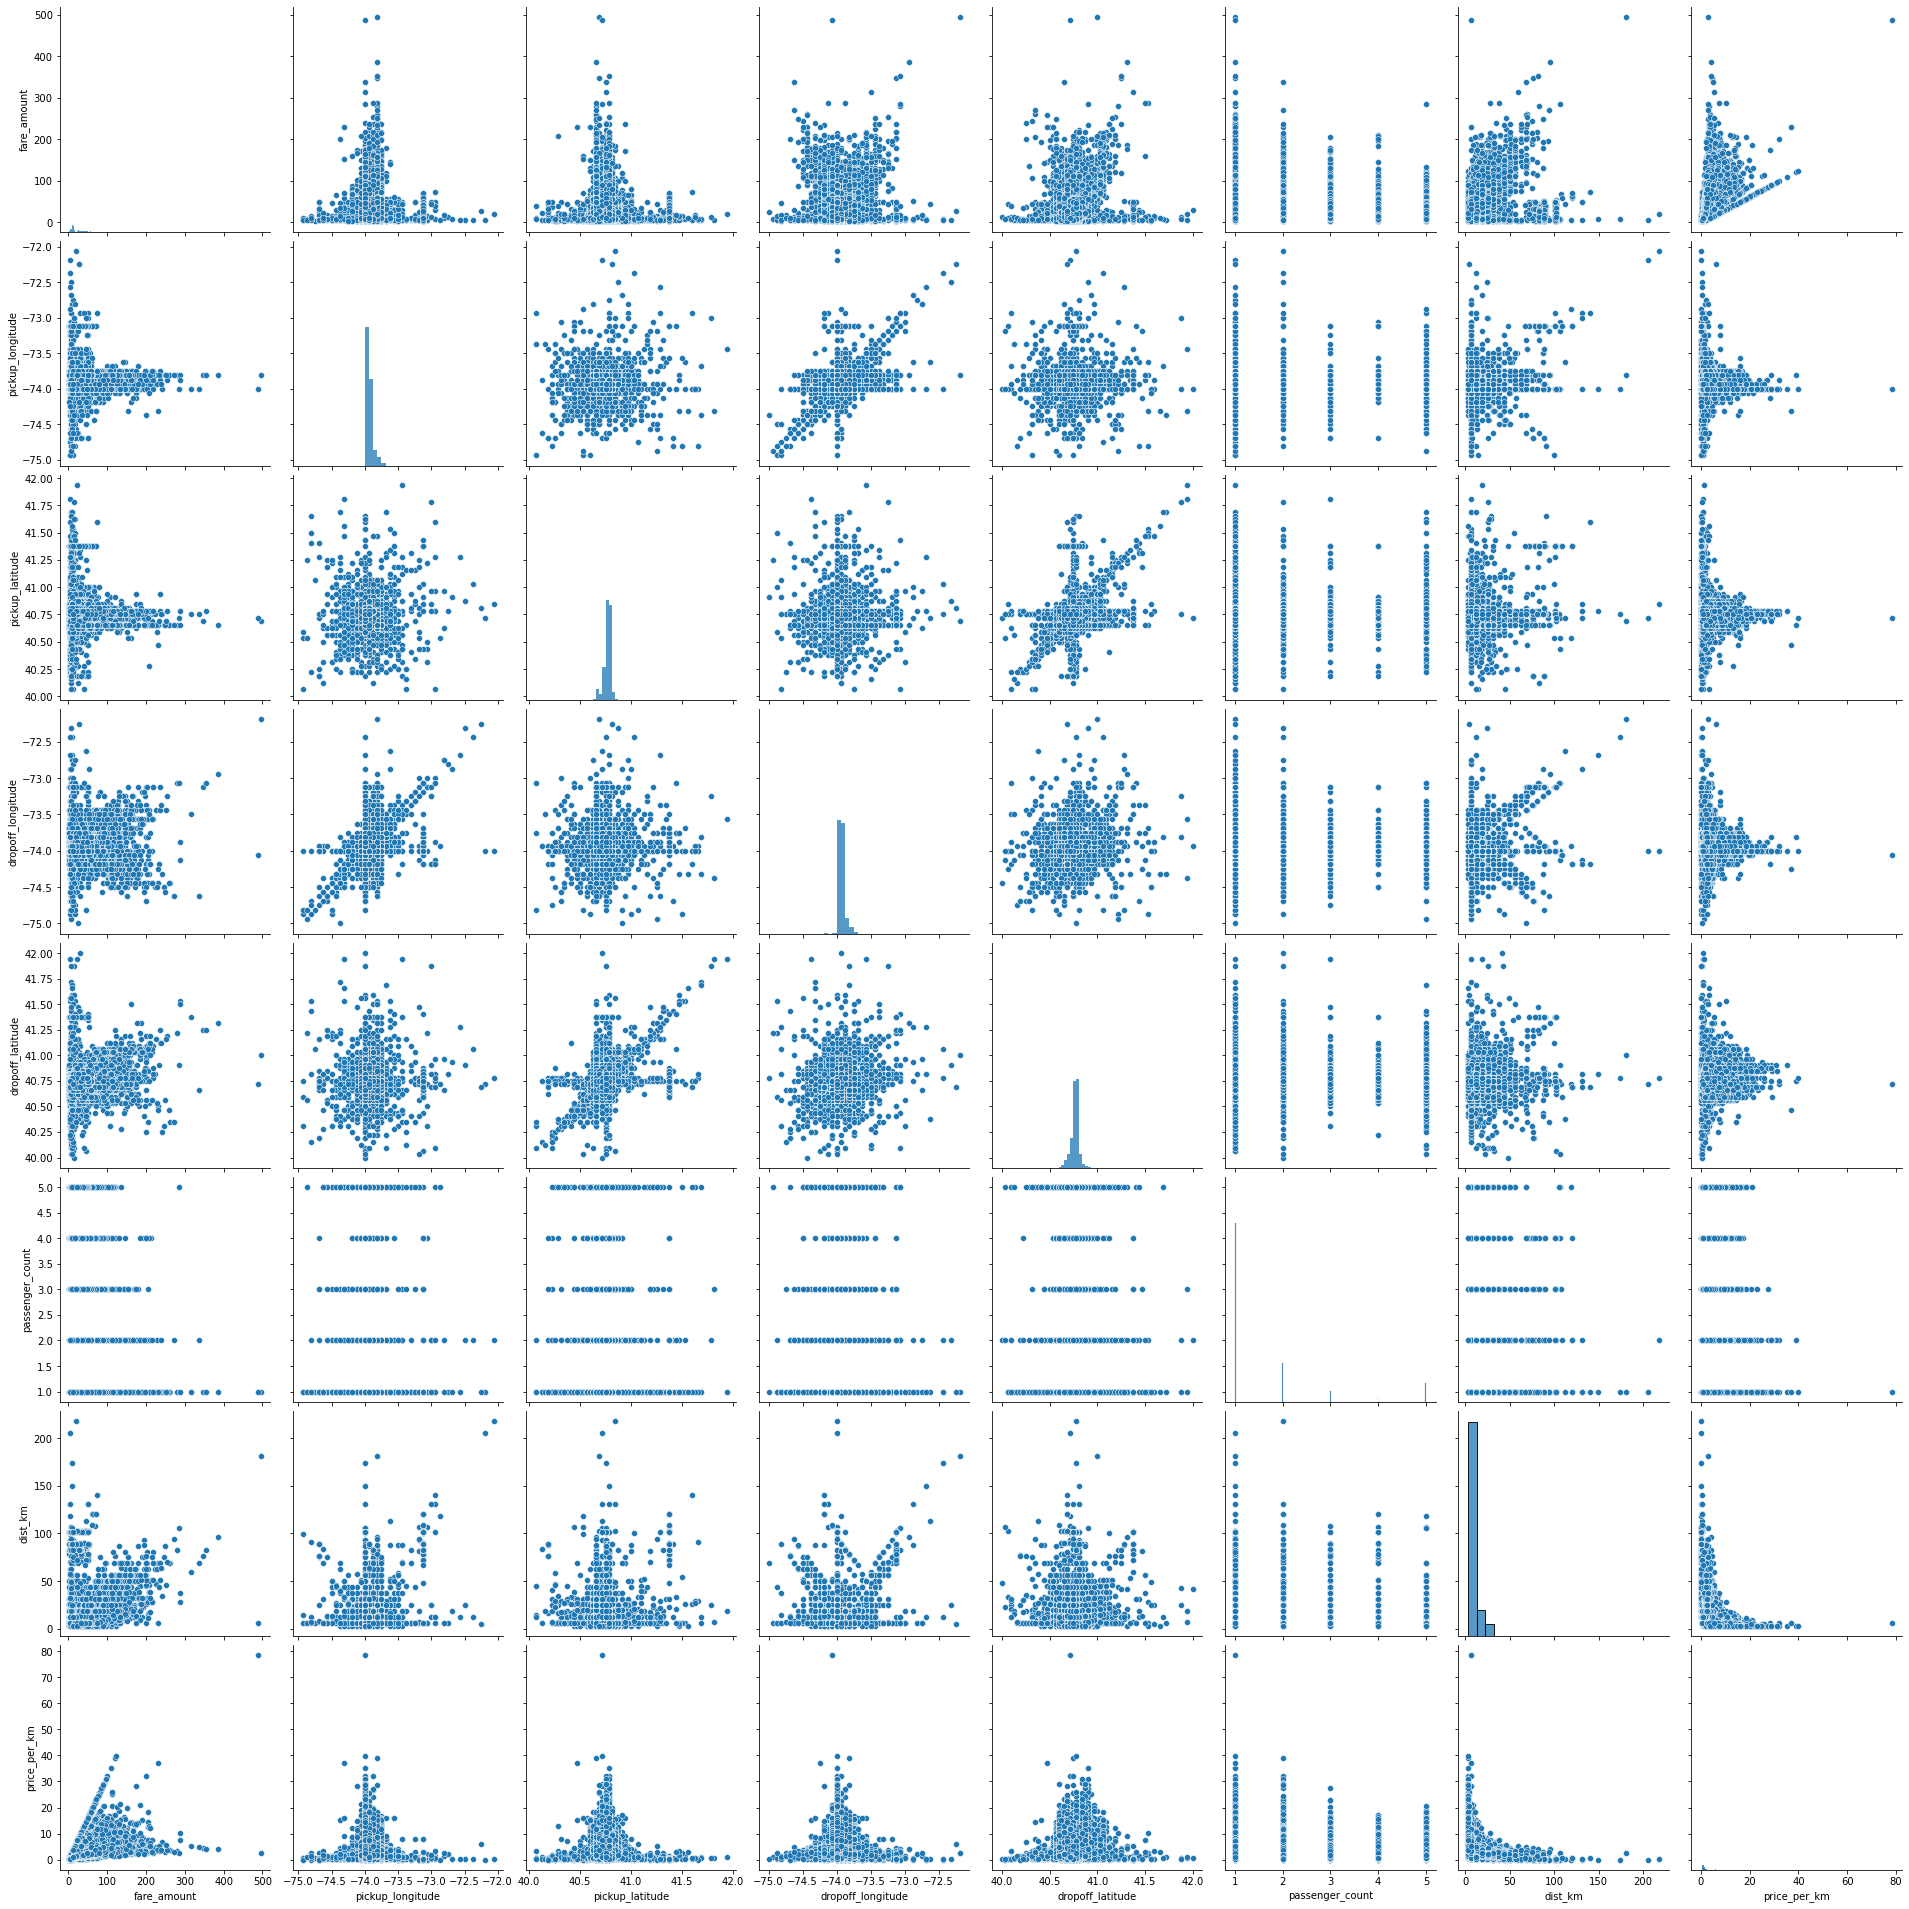

In [83]:
vizualize.pairplot(global_df)
Image(filename=f"{FIGURE_PATH}pairplot.png")  # Show pairplot as image

<AxesSubplot:>

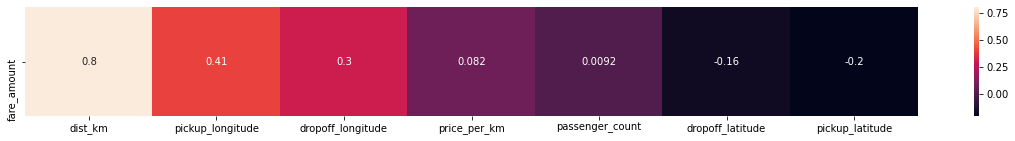

In [99]:
plt.figure(figsize=(20, 2))
sn.heatmap(global_df.corr()[['fare_amount']].sort_values('fare_amount', ascending=False).iloc[1:].T, annot=True)

Fare is highly correlated with distance

## Step 6: Get Predictive

### Train/Test split

In [6]:
df = global_df.drop(["pickup_datetime", "price_per_km", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], axis=1)
X, y = df.drop("fare_amount", axis=1), df["fare_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
del(global_df)
del(df)

### XGBoost

#### XGBoost with Default Parameters

In [10]:
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train({}, dtrain=dtrain, evals=watchlist)
bst.save_model(f"{MODEL_PATH}xgboost.json")

[0]	train-rmse:15.92388	valid-rmse:15.99768
[1]	train-rmse:12.31994	valid-rmse:12.41257
[2]	train-rmse:10.09287	valid-rmse:10.20170
[3]	train-rmse:8.79543	valid-rmse:8.92095
[4]	train-rmse:8.08311	valid-rmse:8.22132
[5]	train-rmse:7.70489	valid-rmse:7.85250
[6]	train-rmse:7.51018	valid-rmse:7.66544
[7]	train-rmse:7.41066	valid-rmse:7.56773
[8]	train-rmse:7.35684	valid-rmse:7.51463
[9]	train-rmse:7.33036	valid-rmse:7.49090


In [105]:
# make prediction
preds = bst.predict(dtest)
prediction = pd.DataFrame({'Prediction': preds})
print(prediction.head())
y_test.head()

   Prediction
0    7.139569
1   12.862584
2   10.724089
3    9.717031
4    5.582827


125698     10.0
2915005    12.9
821889      8.5
75367       8.9
3049264     5.3
Name: fare_amount, dtype: float64

In [106]:
rmse = mean_squared_error(y_test, preds, squared=False).round()
print("RMSE: %.2f" % (rmse))

RMSE: 5.00


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

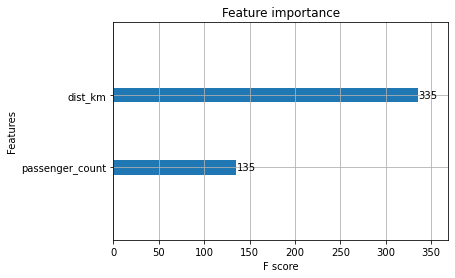

In [52]:
plot_importance(bst)

#### XGBoost With Tuned Parameters (FAILED)

In [95]:
def xgb_opti(eta, gamma, max_depth, subsample, colsample_bytree):
    params = {
        eta: int(eta),
        gamma: int(gamma),
        max_depth: int(max_depth),
        subsample: int(subsample),
        colsample_bytree: int(colsample_bytree)}

    cv_result = xgb.cv(params, dtrain)

    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

xgb_bo = BayesianOptimization(xgb_opti, {"eta": (0, 1), "gamma": (0, 1), "max_depth": (3, 7), "subsample": (0, 1), "colsample_bytree": (0, 1)})
xgb_bo.maximize(init_points=3, n_iter=5, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------


AttributeError: 'numpy.float64' object has no attribute 'encode'

## Random Forest

In [7]:
rf_regr = RandomForestRegressor(random_state=0)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [15]:
# make prediction
preds = rf_regr.predict(X_test)
prediction = pd.DataFrame({'Prediction': preds})
print(prediction.head())
y_test.head()

   Prediction
0   11.047184
1   11.047184
2   11.332343
3   22.571481
4   11.047184


433704      7.699219
154847     18.500000
3970783    28.500000
1134411    24.671875
758943      6.898438
Name: fare_amount, dtype: float16

## Decision tree

In [ ]:
dt_regr = tree.DecisionTreeRegressor(random_state=0)
dt_regr.fit(X_train, y_train)
joblib.dump(rf_regr, f"{MODEL_PATH}dt_regr_compressed.joblib", compress=3)  # compression is ON!

In [ ]:
dt_regr.score(X_test, y_test)

In [ ]:
# make prediction
preds = clf.predict(X_test)
prediction = pd.DataFrame({'Prediction': preds})
print(prediction.head())
y_test.head()